In [8]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jeremykatush","key":"8449af97849ce8c24534bf2a382cf78e"}'}

In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle datasets download -d imtkaggleteam/agriculture-dataset-karnataka

Dataset URL: https://www.kaggle.com/datasets/imtkaggleteam/agriculture-dataset-karnataka
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/41.2k [00:00<?, ?B/s]
100% 41.2k/41.2k [00:00<00:00, 125MB/s]


In [11]:
!unzip agriculture-dataset-karnataka.zip -d agriculture_karnataka_data

Archive:  agriculture-dataset-karnataka.zip
  inflating: agriculture_karnataka_data/data_season.csv  


In [12]:
from pathlib import Path
path = Path('/content/agriculture_karnataka_data')

In [13]:
import pandas as pd
import numpy as np

df = pd.read_csv(f"{path}/data_season.csv")
df.head()

,Year,Location,Area,Rainfall,Temperature,Soil type,Irrigation,yeilds,Humidity,Crops,price,Season
0,2004,Mangalore,1279,2903.1,27.0,Alluvial,Drip,2570.0,57.0,Coconut,200000,Kharif
1,2004,Mangalore,13283,2903.1,27.0,Alluvial,Drip,27170.0,57.5,Coconut,4847,Kharif
2,2004,Mangalore,52119,2903.1,27.0,Alluvial,Drip,114744.0,57.0,Coconut,51239,Kharif
3,2004,Mangalore,725,2996.6,27.0,Alluvial,Drip,1402.0,55.0,Coconut,216396,Kharif
4,2004,Mangalore,12885,2996.6,27.0,Alluvial,Drip,23456.0,56.0,Coconut,2644,Kharif


In [5]:
!pwd

/content


In [7]:
!ls -al

total 16
drwxr-xr-x 1 root root 4096 Jul 16 13:48 .
drwxr-xr-x 1 root root 4096 Jul 18 11:13 ..
drwxr-xr-x 4 root root 4096 Jul 16 13:47 .config
drwxr-xr-x 1 root root 4096 Jul 16 13:48 sample_data


In [20]:
import janitor

df = janitor.clean_names(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3158 entries, 0 to 3157
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         3158 non-null   int64  
 1   location     3158 non-null   object 
 2   area         3158 non-null   int64  
 3   rainfall     3158 non-null   float64
 4   temperature  3158 non-null   float64
 5   soil_type    3100 non-null   object 
 6   irrigation   3158 non-null   object 
 7   yeilds       3158 non-null   float64
 8   humidity     3158 non-null   float64
 9   crops        3158 non-null   object 
 10  price        3158 non-null   int64  
 11  season       3158 non-null   object 
dtypes: float64(4), int64(3), object(5)
memory usage: 296.2+ KB


In [21]:
df.columns.to_list()

['year',
 'location',
 'area',
 'rainfall',
 'temperature',
 'soil_type',
 'irrigation',
 'yeilds',
 'humidity',
 'crops',
 'price',
 'season']

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [27]:
data = df

data = data.rename(columns={'yeilds': 'yields'})
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
target = 'yields'

In [28]:
# 3. Separate features and target
X = data[categorical_features + numerical_features]
y = data[target]

In [30]:
# 4. Define preprocessors
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# 5. Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [31]:
# 6. Fit-transform features
X_preprocessed = preprocessor.fit_transform(X)

# 7. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# 8. Build TensorFlow model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)  # Regression output
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [33]:
# 9. Train model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32)

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 4120177664.0000 - mae: 21667.9531 - val_loss: 3871691008.0000 - val_mae: 23672.3965
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4333896192.0000 - mae: 24215.4883 - val_loss: 3863894784.0000 - val_mae: 23580.7012
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3811639552.0000 - mae: 22274.0176 - val_loss: 3837872128.0000 - val_mae: 23346.1660
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3989633024.0000 - mae: 24006.3438 - val_loss: 3784657408.0000 - val_mae: 23000.2949
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3511487488.0000 - mae: 22265.7812 - val_loss: 3691755776.0000 - val_mae: 22682.4727
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4446230016.0000 - mae: 23393.6758 - val_loss: 3567571200.0000 - val_mae: 22822.1973
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3057624064.0000 - mae: 21743.6465 - val_loss: 3414694912.0000 - val_mae: 23510.880

In [34]:
# 10. Evaluate model
y_pred = model.predict(X_test).flatten()
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'MSE: {mse:.2f}, MAE: {mae:.2f}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
MSE: 2618502.96, MAE: 887.82


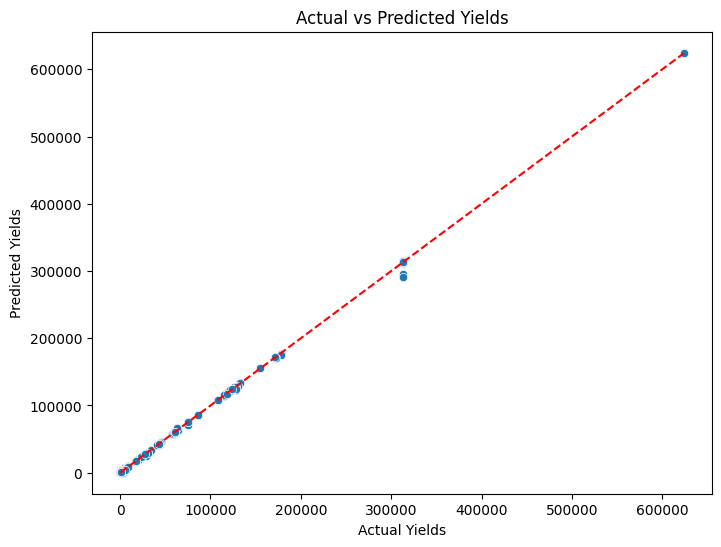

In [35]:
# 11. Visualize prediction
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Yields")
plt.ylabel("Predicted Yields")
plt.title("Actual vs Predicted Yields")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

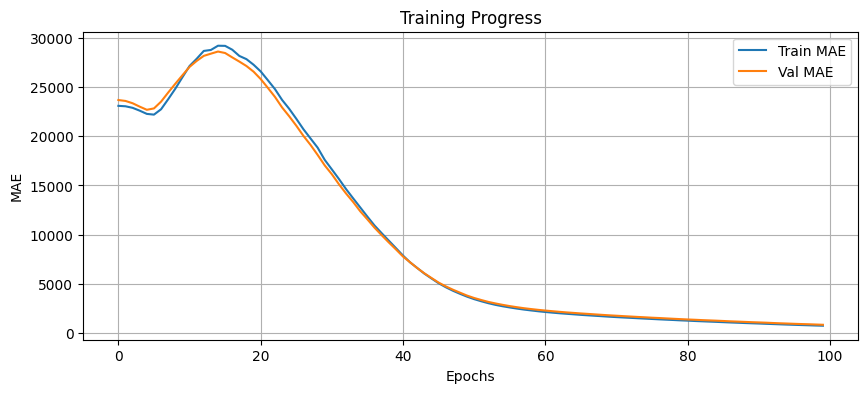

In [36]:
# 12. Visualize training
plt.figure(figsize=(10, 4))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Training Progress')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid()
plt.show()

In [38]:
# 13. Save model and preprocessor
model.save("yield_predictor_model.keras")
import joblib
joblib.dump(preprocessor, "yield_preprocessor.pkl")

['yield_preprocessor.pkl']

In [ ]:
# Load model
loaded_model = tf.keras.models.load_model("yield_predictor_model.keras")